In [1]:
import tensorflow as tf

/home/yash/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from scipy import io as spio
import keras
import numpy as np

Using TensorFlow backend.


In [3]:
emnist = spio.loadmat("matlab/emnist-byclass.mat")

In [4]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

In [5]:
# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

In [6]:
# store labels for visualization
train_labels = y_train
test_labels = y_test

In [8]:
y_train = keras.utils.to_categorical(y_train, 62) 
y_test = keras.utils.to_categorical(y_test, 62)



In [7]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=uint8)

In [38]:
def next_batch(batch_size,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [11]:
# normalize
x_train /= 255
x_test /= 255

In [12]:
# reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order="A")
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order="A")

TypeError: Invalid dimensions for image data

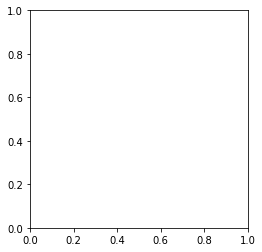

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
img = x_train[697]

# visualize image
plt.imshow(img[0], cmap='gray')

### helper functions

In [13]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [14]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [15]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [16]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [17]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [18]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

#### placeholder

In [19]:
x = tf.placeholder(tf.float32,shape=[None,784])

In [20]:
y_true = tf.placeholder(tf.float32,shape=[None,47])

#### layers

In [21]:
x_image = tf.reshape(x,[-1,28,28,1])

In [22]:
convo_1 = convolutional_layer(x_image,shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [23]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [24]:
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [25]:
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [26]:
y_pred = normal_full_layer(full_one_dropout,10)

In [27]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

In [29]:
init = tf.global_variables_initializer()

In [30]:
saver = tf.train.Saver()

In [41]:
batch_size=50

In [43]:
steps = 5000

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x , batch_y = next_batch(batch_size)
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:emnist.test.images,y_true:emnist.test.labels,hold_prob:1.0}))
            print('\n')
    saver.save(sess,"./emnist_model_tf")

AttributeError: 'int' object has no attribute 'xmax'